In [1]:
# !pip install xgboost==0.90
# !pip install catboost==0.18.1
# !pip install shap

In [2]:
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# load JS visualization code to notebook
shap.initjs()

/Users/evgenijgrinev/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Градиетный бустинг "на пальцах"

In [3]:
x = np.arange(0, 50)
x = pd.DataFrame({"x": x})

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]
y.shape

(50, 1)

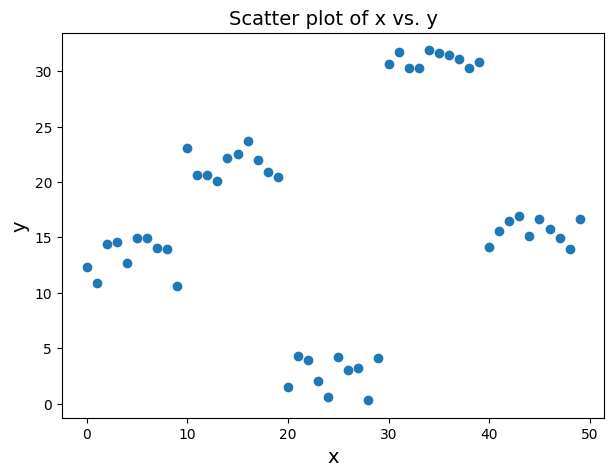

In [4]:
plt.figure(figsize=(7,5))
plt.plot(x, y, "o")
plt.title("Scatter plot of x vs. y", size=14)
plt.xlabel("x", size=14)
plt.ylabel("y", size=14)

plt.show()

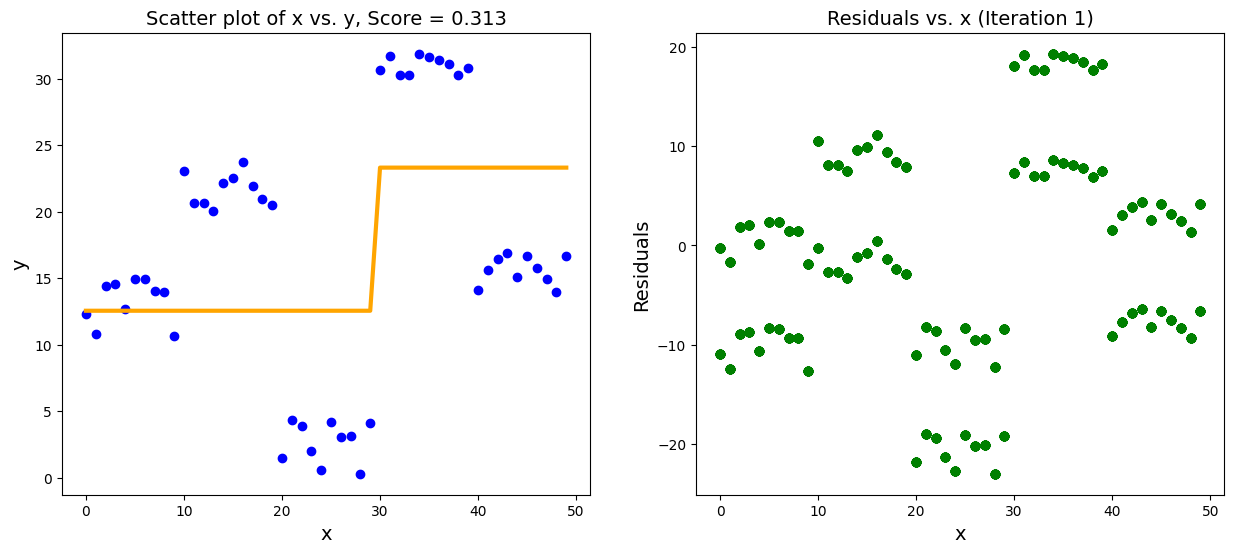

ValueError: non-broadcastable output operand with shape (50,) doesn't match the broadcast shape (50,50)

In [5]:
trees = []
y_ = y.copy()

for i in range(4):

    tree = DecisionTreeRegressor(max_depth=1, random_state=27)
    tree.fit(x, y_)

    trees.append(tree)
    y_pred = 0

    for tree in trees:
        y_pred += tree.predict(x)

    residuals = y_ - y_pred
    y_ = residuals
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

## А как работает бэггинг?

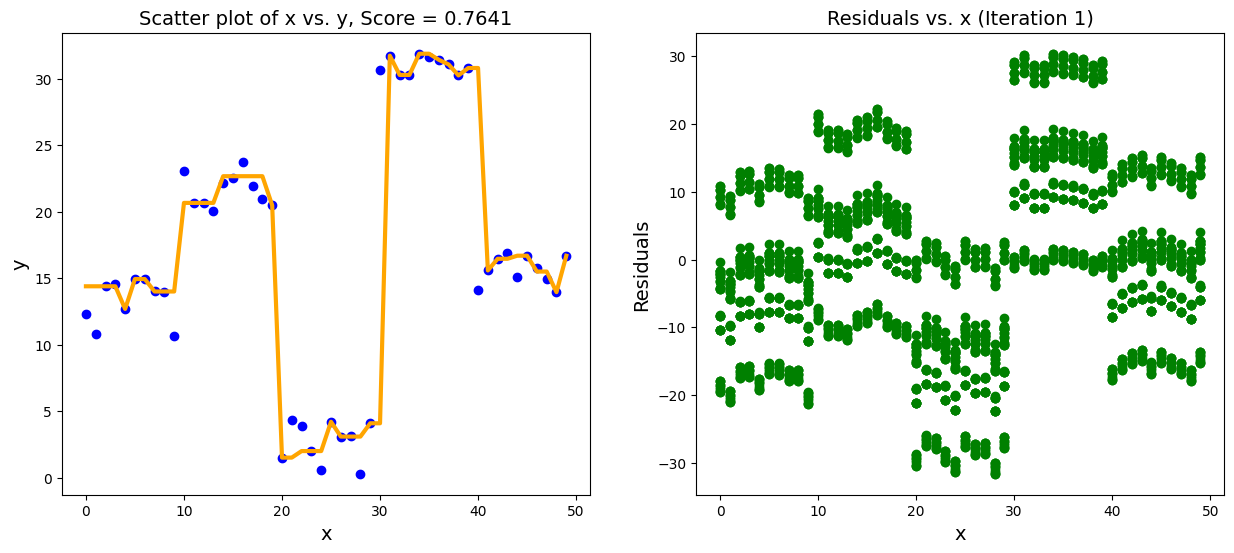

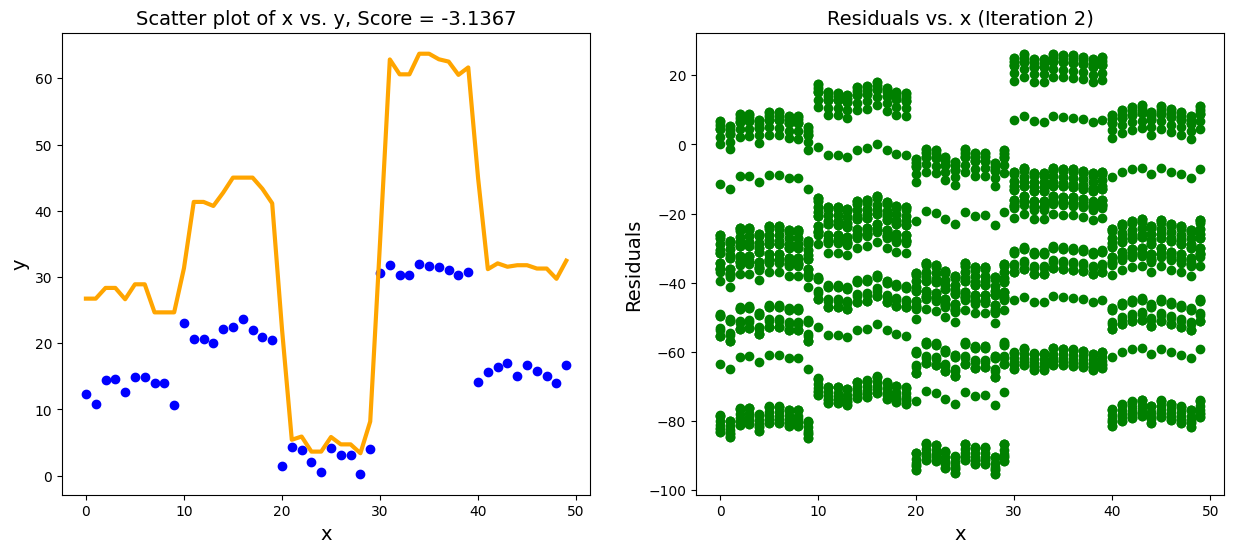

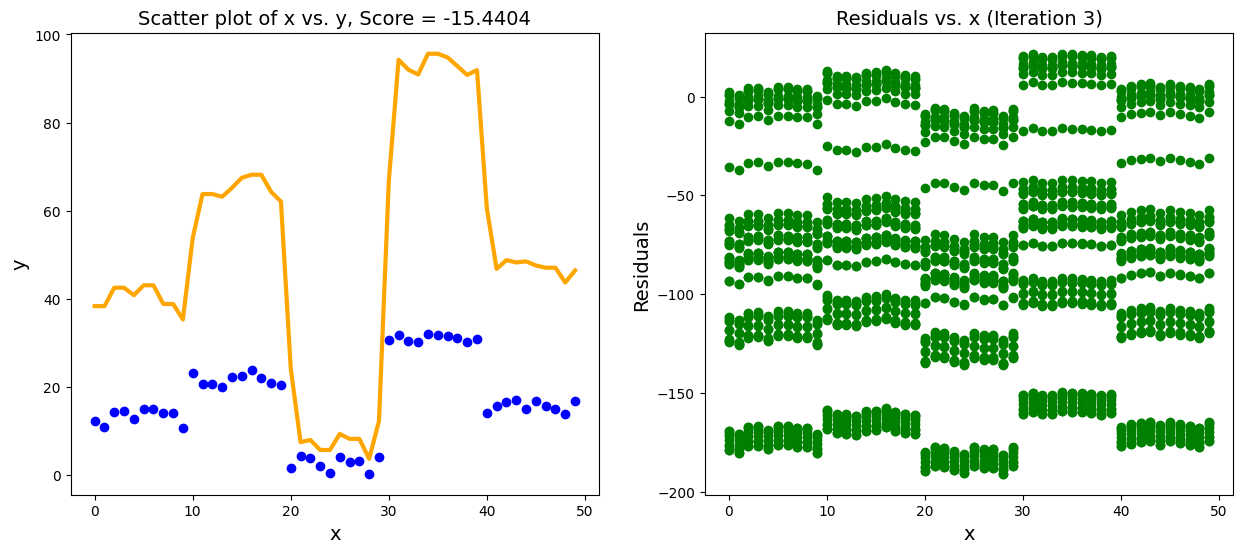

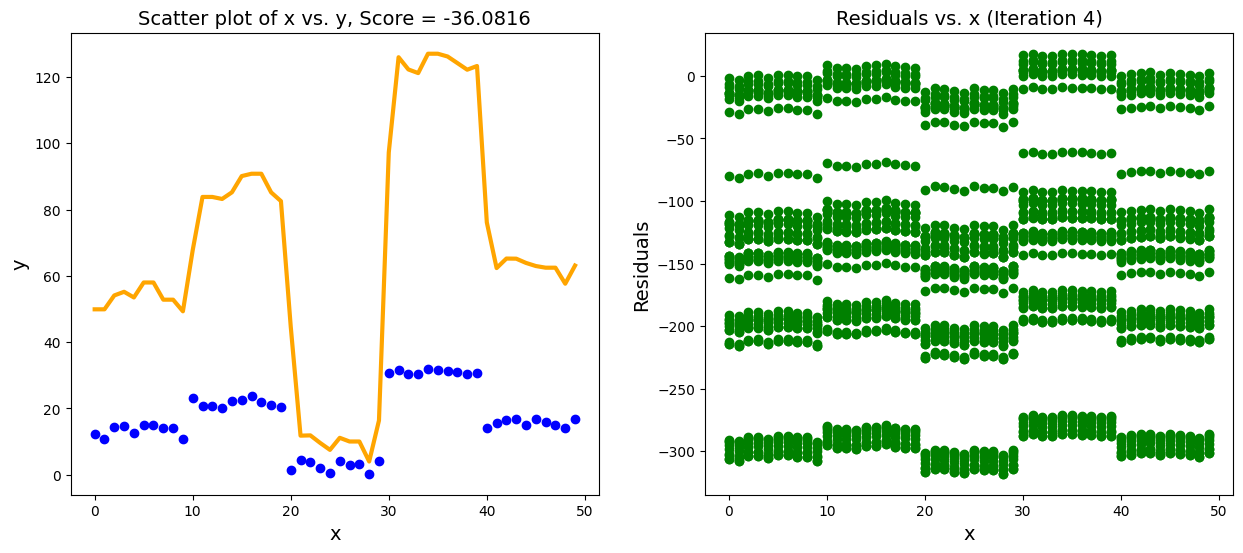

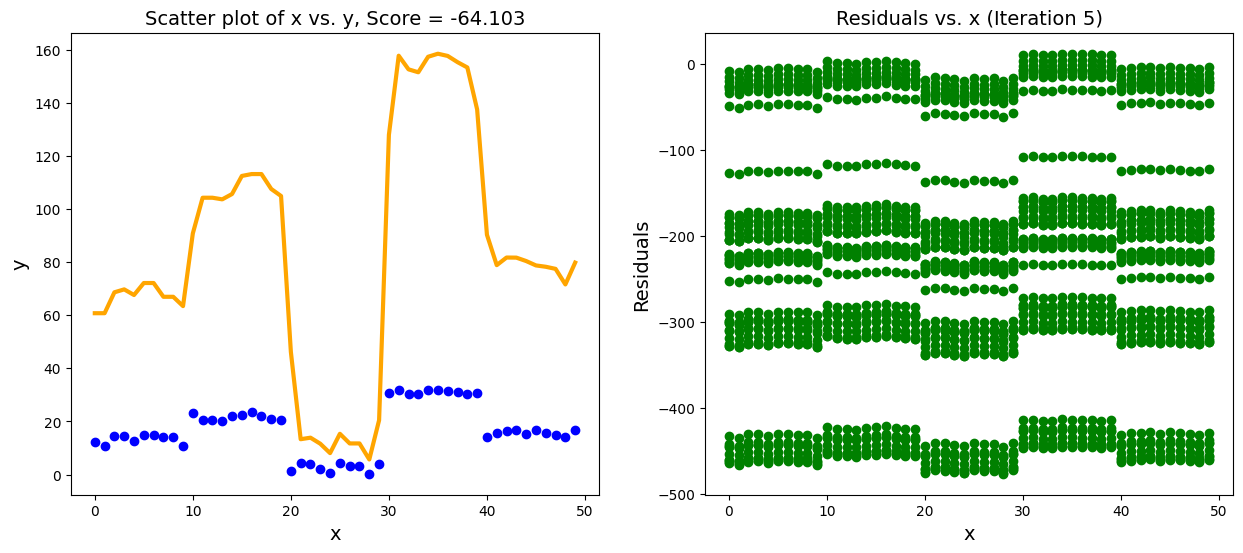

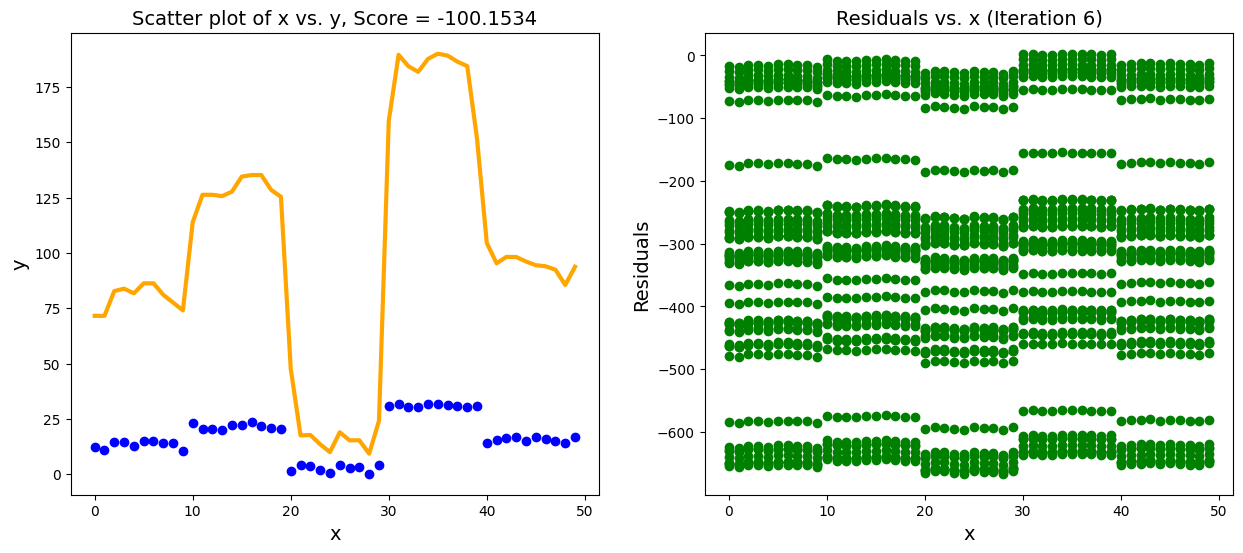

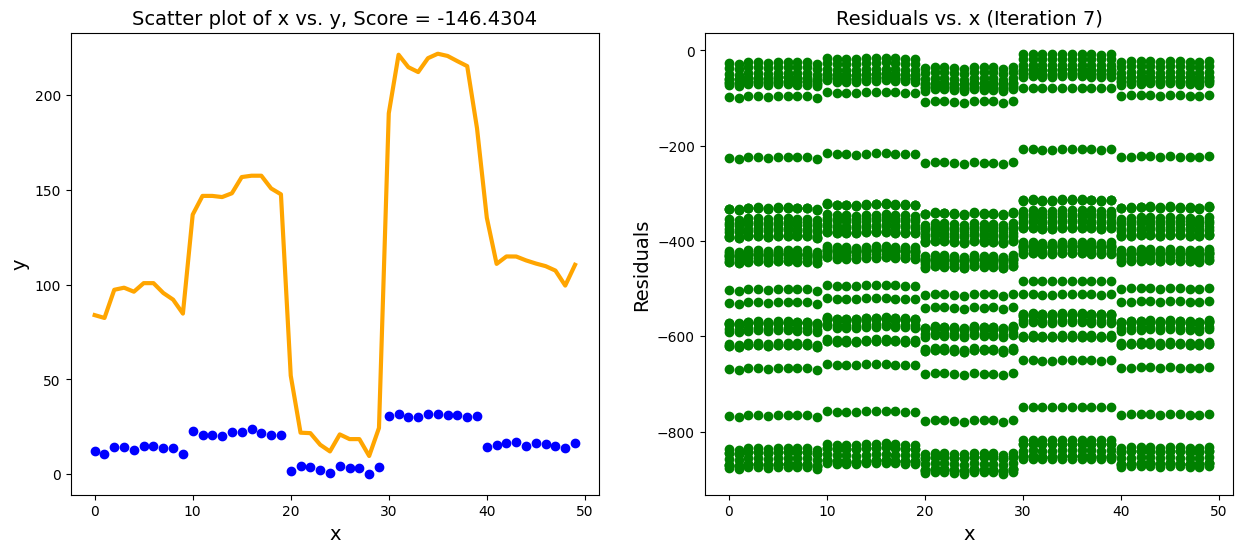

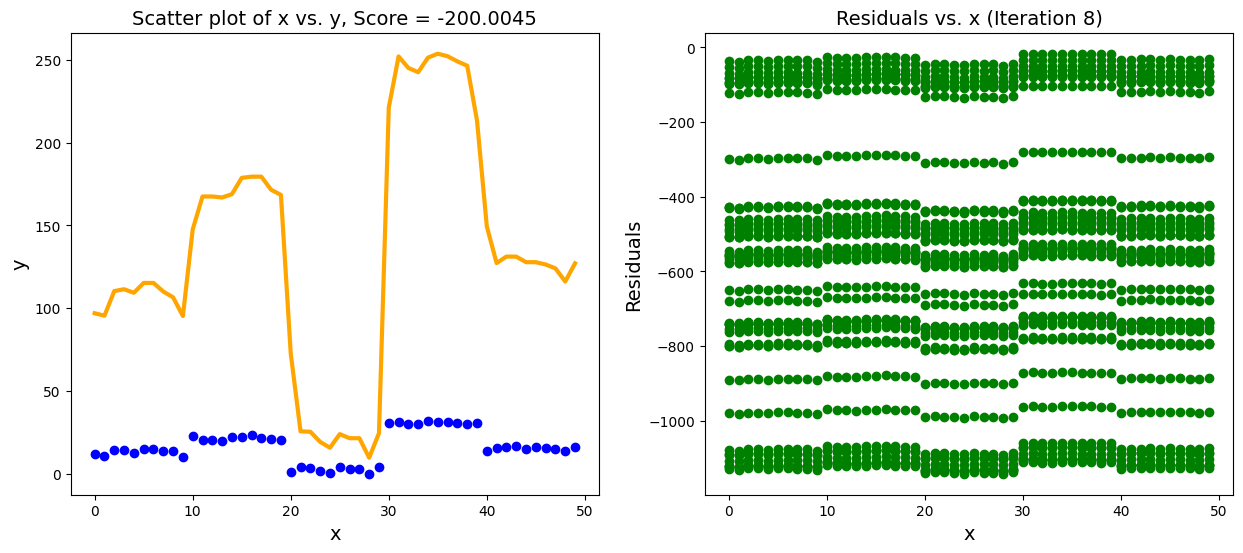

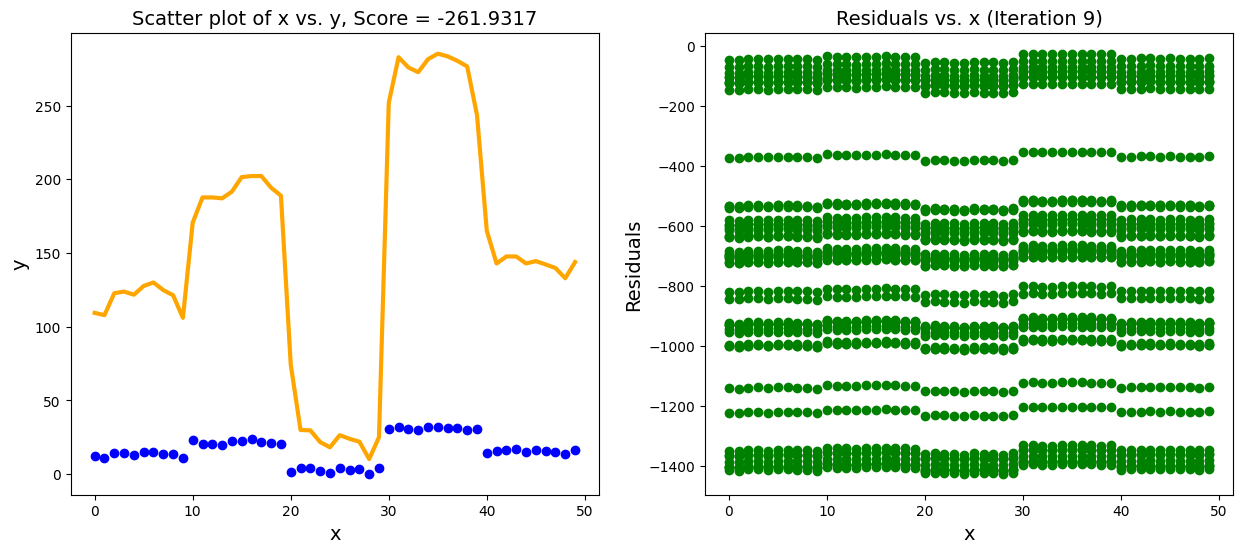

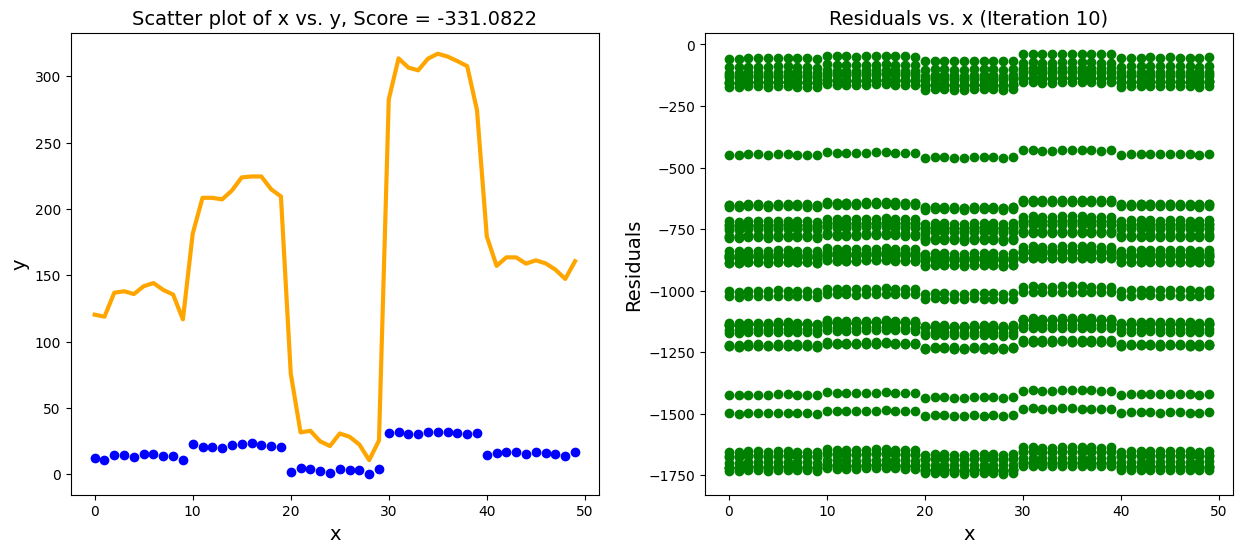

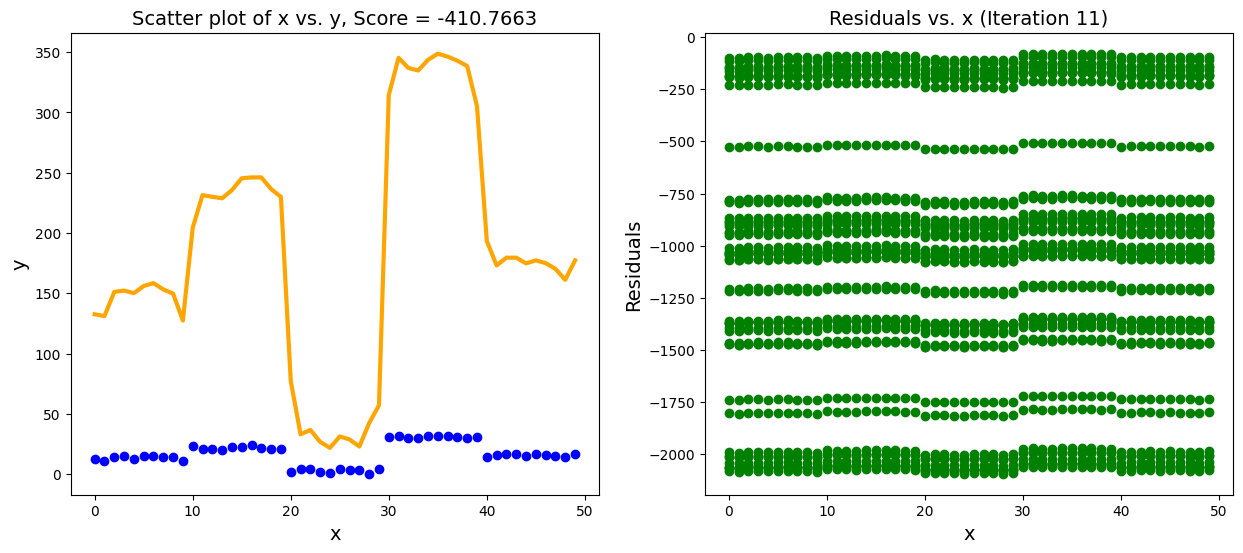

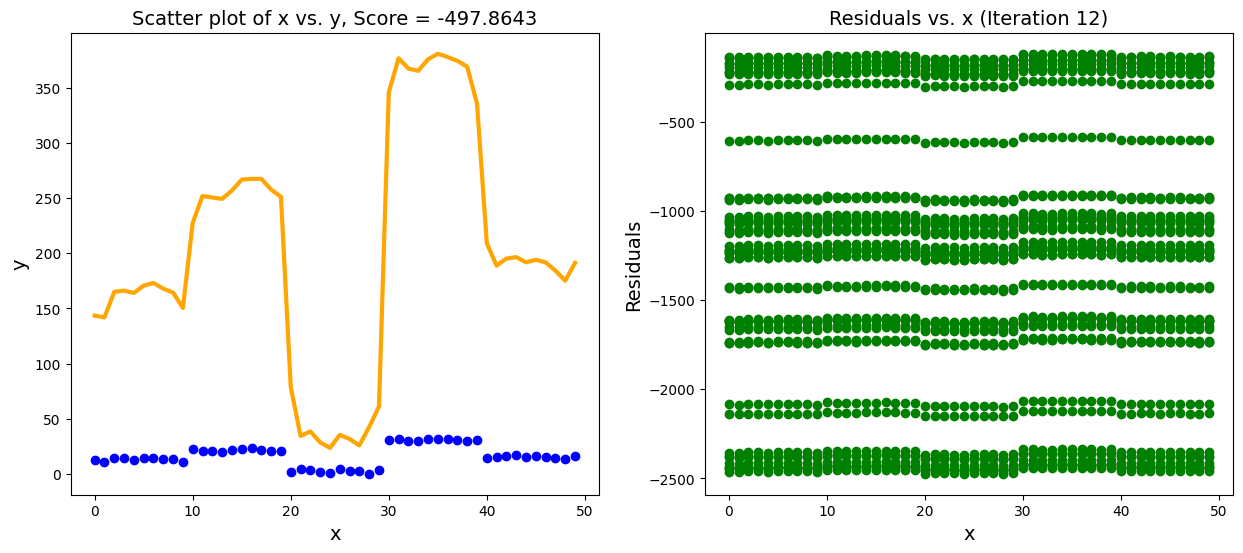

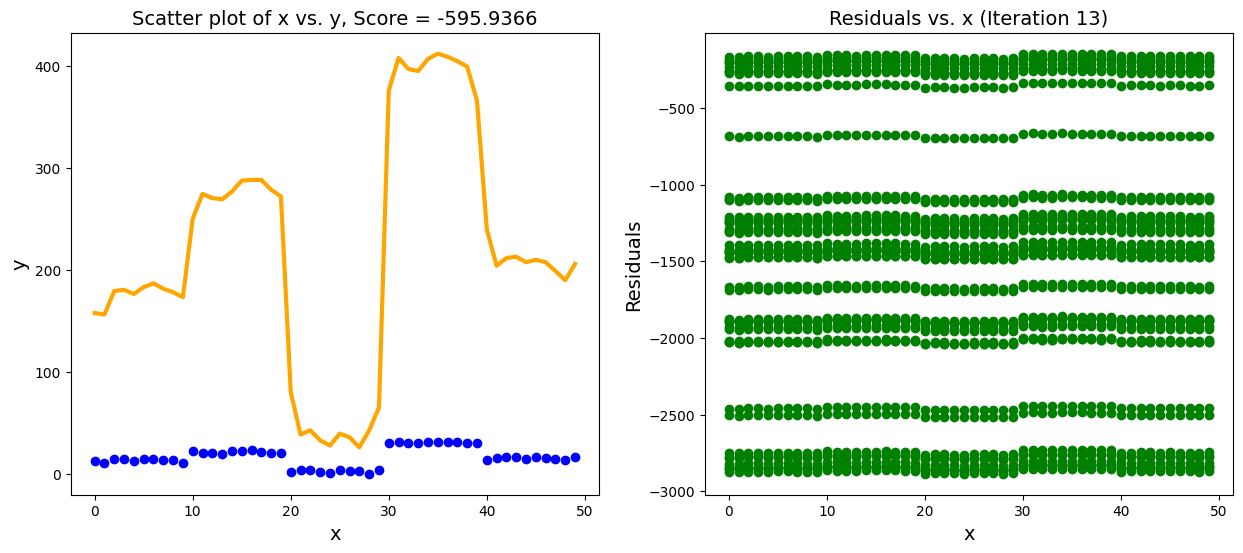

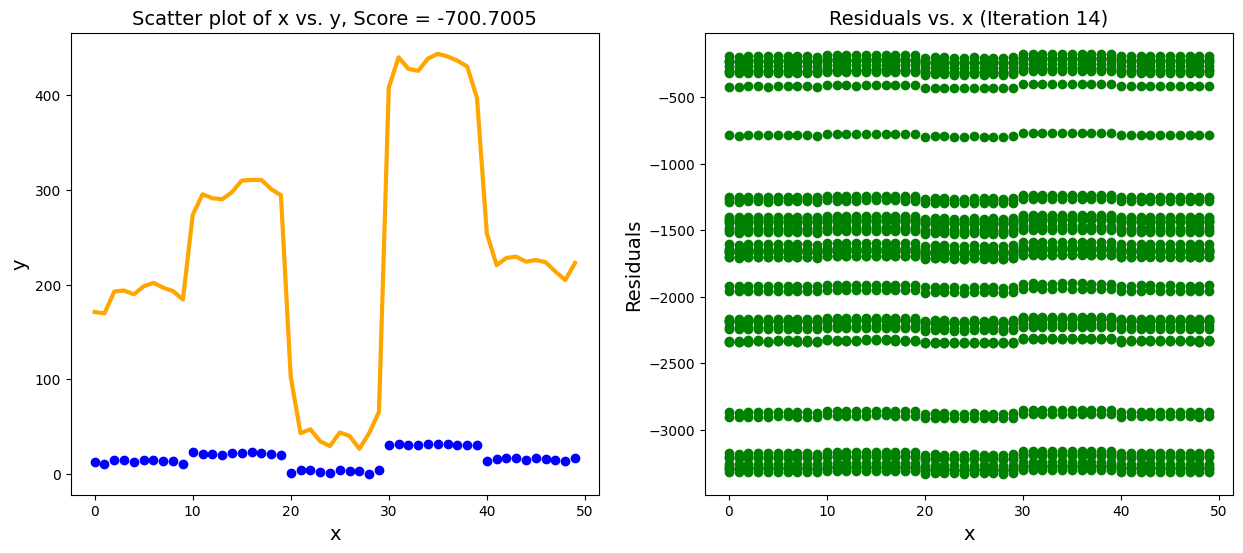

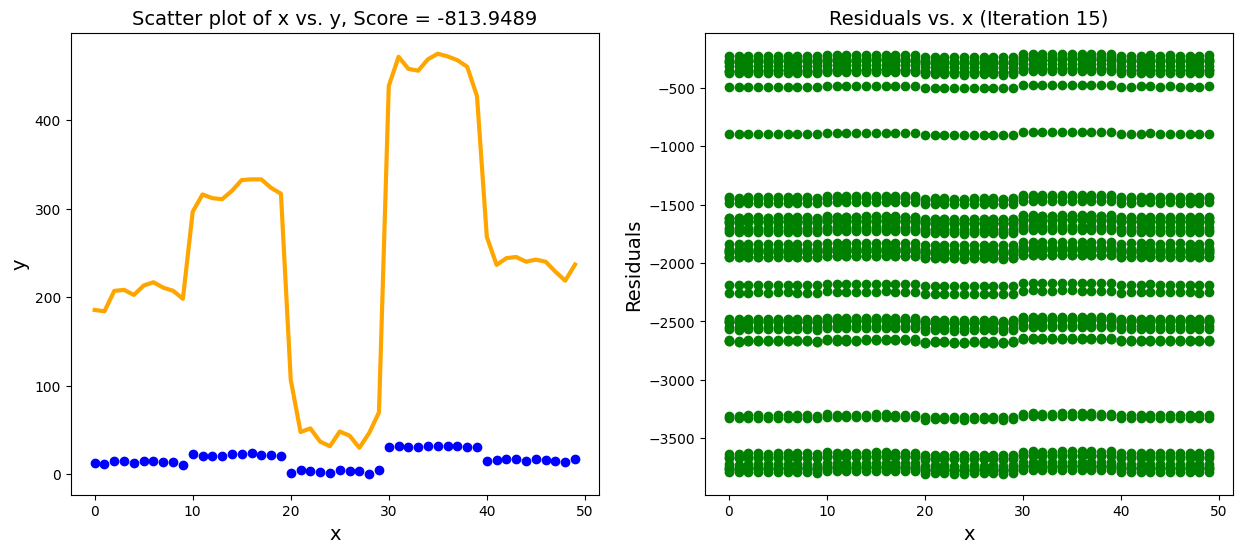

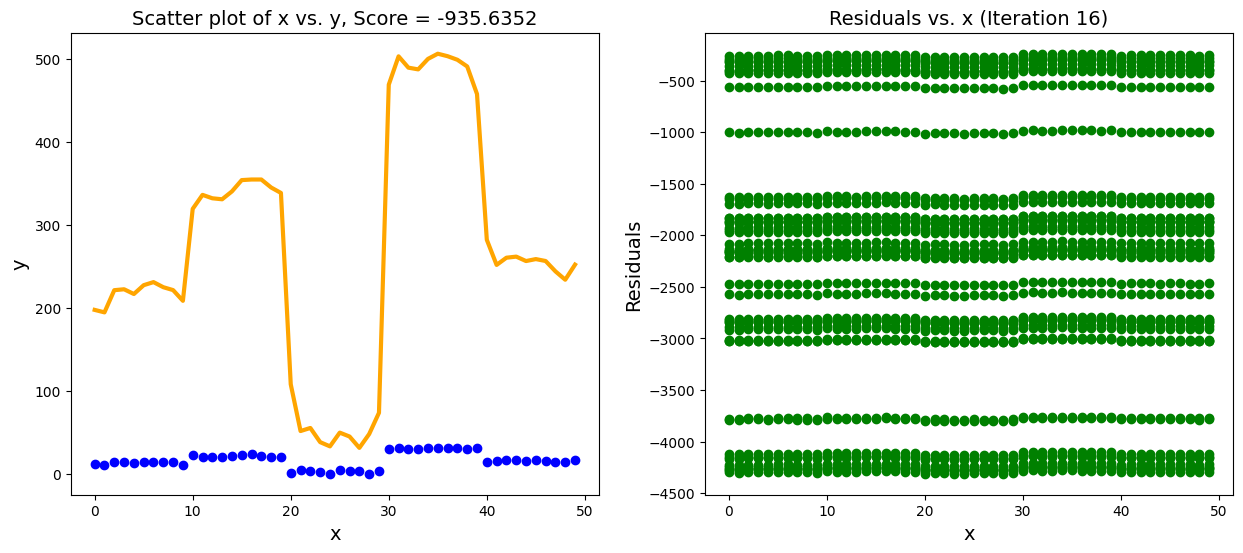

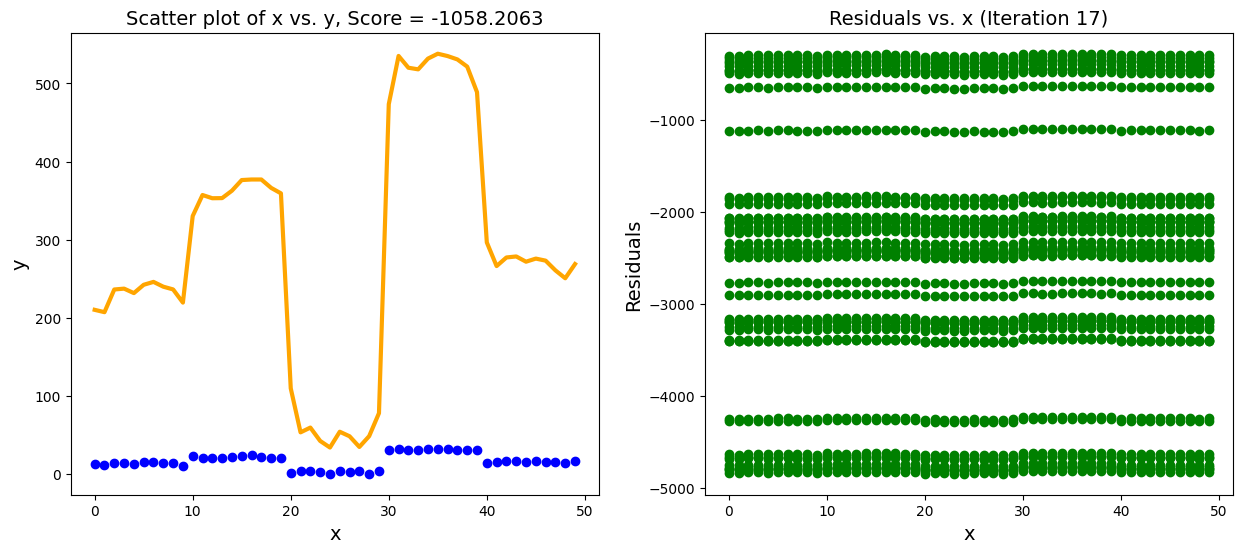

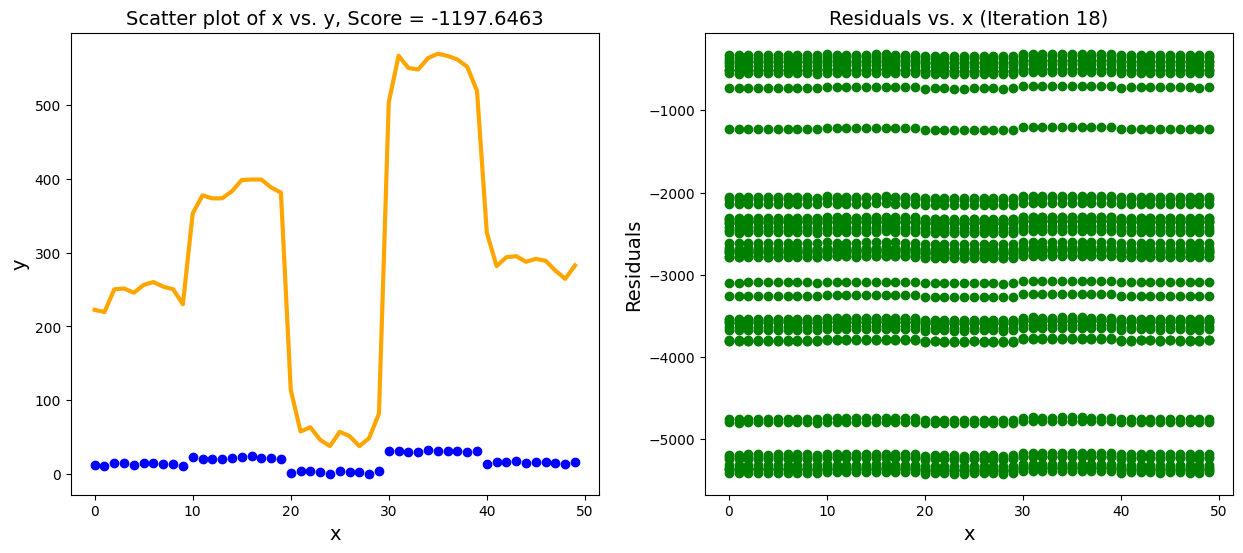

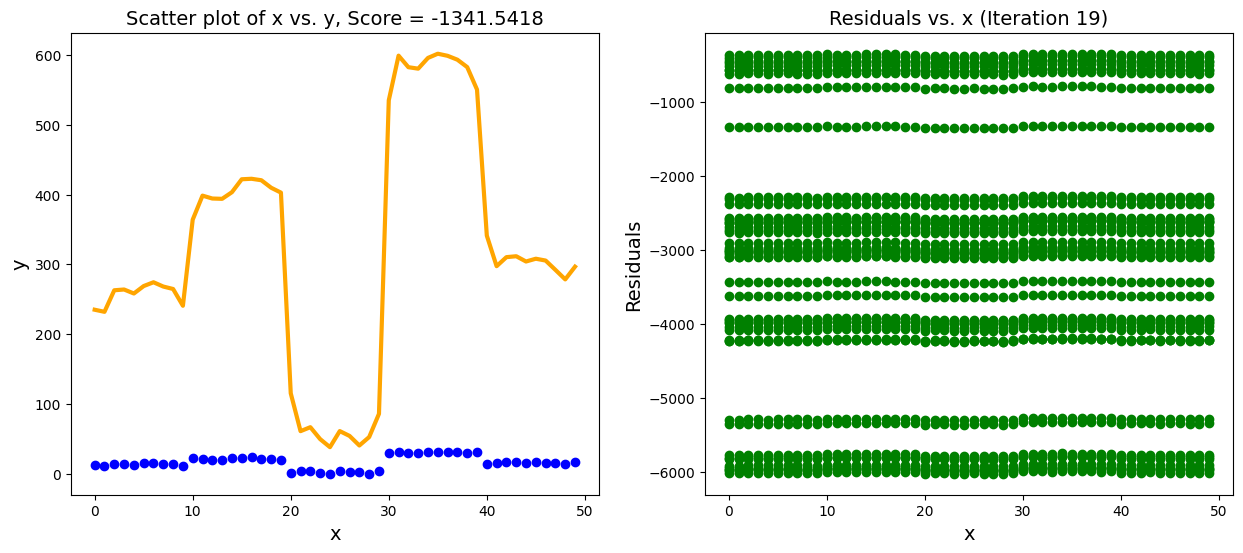

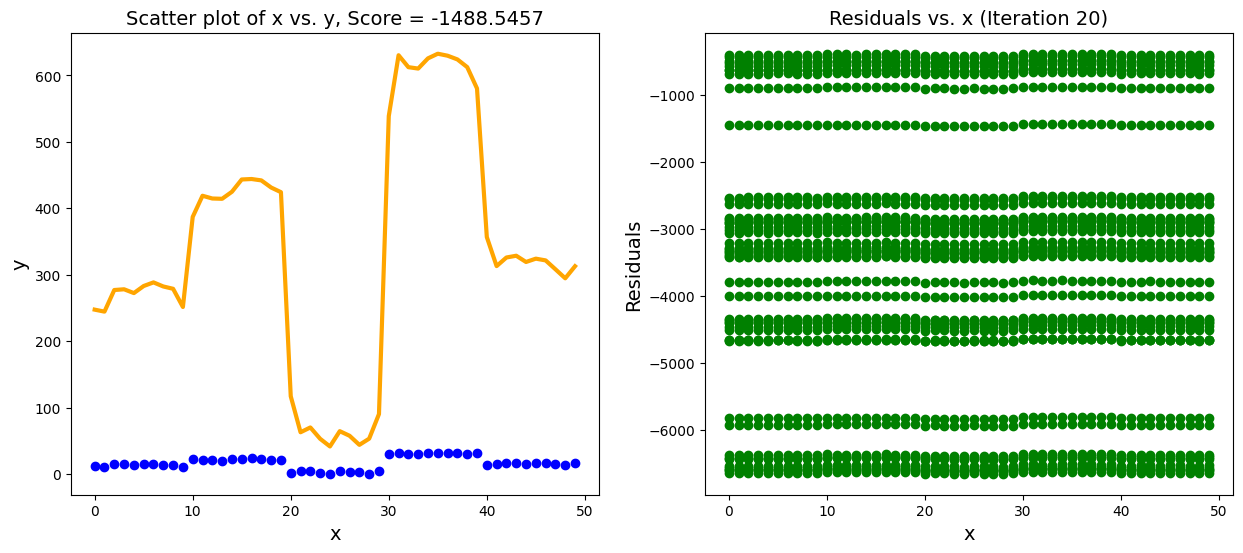

In [6]:
trees = []
y_ = y.copy()

for i in range(20):

    idx = np.random.randint(0, len(x), size=len(x))
    tree = DecisionTreeRegressor(max_depth=5, random_state=27)
    tree.fit(x.loc[idx], y[idx])

    trees.append(tree)
    y_pred = 0

    for tree in trees:
        y_pred += tree.predict(x)

    residuals = y_ - y_pred
    y_ = residuals
    score = r2_score(
        y, y_pred
    )

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.plot(x, y, "o", color="blue")
    plt.plot(x, y_pred, color="orange", linewidth=3)
    plt.title(f"Scatter plot of x vs. y, Score = {round(score, 4)}", size=14)
    plt.xlabel("x", size=14)
    plt.ylabel("y", size=14)

    plt.subplot(122)
    plt.plot(x, residuals, "o", color="green")
    plt.title(f"Residuals vs. x (Iteration {i+1})", size=14)
    plt.ylabel("Residuals", size=14)
    plt.xlabel("x", size=14)
    plt.show()

## Загрузка данных

In [7]:
data = pd.read_csv("./train.csv")
data.head(n=2)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.093,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.389,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518


In [8]:
x_train, x_valid = train_test_split(
    data.drop(["ID_code", "target"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    data["target"], train_size=0.7, random_state=1
)

## 1. Обучение базовой модели XGBoost (sklearn-API)

`XGBoost` поддерживает как свое собственное API, так и `sklearn-API`.

In [9]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(random_state=27)

In [10]:
y_pred = baseline.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8173


## 2. Обучение модели XGBoost с использование оригинального API

In [11]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "nthread": 6,
    "gamma": 10,
    "seed": 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [ ]:
dtrain

In [12]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=25,
    
)

[0]	train-auc:0.535874	valid-auc:0.522539
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.79598	valid-auc:0.734062
[50]	train-auc:0.847714	valid-auc:0.776335
[75]	train-auc:0.876546	valid-auc:0.802633
[100]	train-auc:0.895706	valid-auc:0.817144
[125]	train-auc:0.908324	valid-auc:0.827664
[150]	train-auc:0.917521	valid-auc:0.836664
[175]	train-auc:0.923779	valid-auc:0.842864
[200]	train-auc:0.929381	valid-auc:0.848008
[225]	train-auc:0.933061	valid-auc:0.85123
[250]	train-auc:0.936981	valid-auc:0.85522
[275]	train-auc:0.94039	valid-auc:0.856979
[300]	train-auc:0.942774	valid-auc:0.85915
[325]	train-auc:0.945224	valid-auc:0.860701
[350]	train-auc:0.947117	valid-auc:0.862229
[375]	train-auc:0.948777	valid-auc:0.863689
[400]	train-auc:0.950363	valid-auc:0.864912
[425]	train-auc:0.95128	valid-auc:0.866331
[450]	train-auc:0.951616	valid-auc:0.866878
[475]	train-auc:0.951739	valid-a

In [ ]:
# evals_result

Text(0, 0.5, 'ROC-AUC')

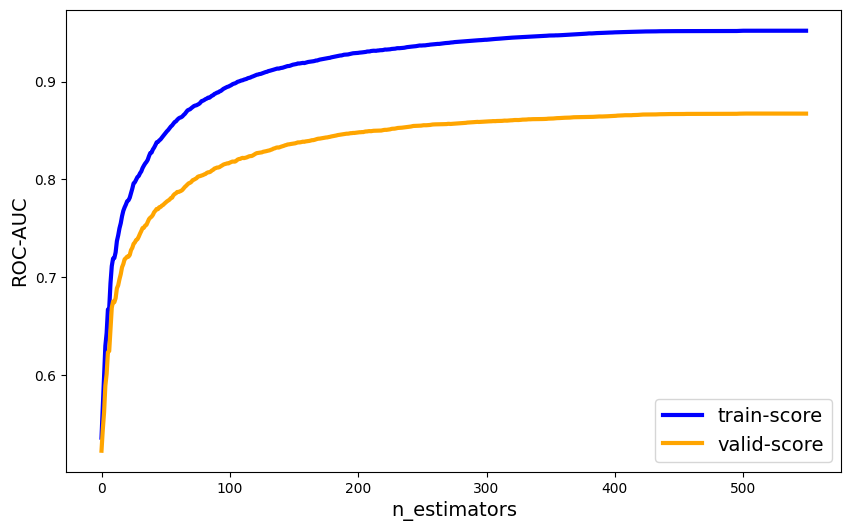

In [13]:
fig = plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["auc"], linewidth=3, label="train-score", color="blue")
plt.plot(evals_result["valid"]["auc"], linewidth=3, label="valid-score", color="orange")
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

In [14]:
cv_score = xgb.cv(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=25,
    maximize=True,
    nfold=3,
)

[0]	train-auc:0.506997+0.00227279	test-auc:0.502616+0.0016775
[25]	train-auc:0.79962+0.00570583	test-auc:0.750186+0.00522845
[50]	train-auc:0.853181+0.00495827	test-auc:0.785345+0.00584787
[75]	train-auc:0.886262+0.00619125	test-auc:0.808374+0.00521186
[100]	train-auc:0.902804+0.00481189	test-auc:0.822285+0.00552684
[125]	train-auc:0.915166+0.00411315	test-auc:0.832244+0.00610349
[150]	train-auc:0.924162+0.00418319	test-auc:0.840553+0.00642424
[175]	train-auc:0.930429+0.00398267	test-auc:0.845827+0.00632343
[200]	train-auc:0.935598+0.00421615	test-auc:0.850197+0.00687476
[225]	train-auc:0.939888+0.00376806	test-auc:0.853634+0.00734655
[250]	train-auc:0.943402+0.00353726	test-auc:0.856298+0.00759503
[275]	train-auc:0.946075+0.00348201	test-auc:0.858379+0.00728405
[300]	train-auc:0.948385+0.00348639	test-auc:0.86058+0.00737802
[325]	train-auc:0.950242+0.00323236	test-auc:0.862499+0.00779128
[350]	train-auc:0.951117+0.00302754	test-auc:0.863132+0.00761819
[375]	train-auc:0.951695+0.002721

Text(0, 0.5, 'ROC-AUC')

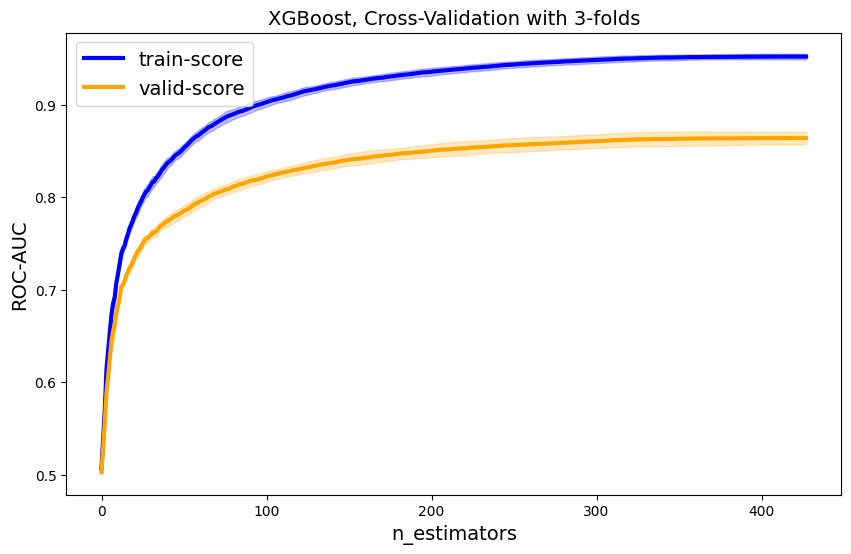

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.title("XGBoost, Cross-Validation with 3-folds", size=14)
plt.plot(
    cv_score["train-auc-mean"],
    label="train-score",
    linewidth=3,
    color="blue"
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["train-auc-mean"]-cv_score["train-auc-std"],
    y2=cv_score["train-auc-mean"]+cv_score["train-auc-std"],
    color="blue", alpha=0.25
)
plt.plot(
    cv_score["test-auc-mean"],
    label="valid-score",
    color="orange",
    linewidth=3
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["test-auc-mean"]-cv_score["test-auc-std"],
    y2=cv_score["test-auc-mean"]+cv_score["test-auc-std"],
    color="orange", alpha=0.25
)
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

## 3. Интерпретация работы модели XGBoost

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)
shap_values

array([[ 0.0449302 , -0.08578412, -0.06567662, ...,  0.13820183,
        -0.08224826,  0.0094004 ],
       [-0.05525257, -0.07376926, -0.08008064, ...,  0.03028343,
         0.02824473, -0.05966273],
       [-0.07606319, -0.03098708,  0.15997346, ...,  0.02521579,
         0.05509485, -0.00505044],
       ...,
       [ 0.30123696,  0.07653812,  0.1025651 , ..., -0.0996654 ,
         0.11571566, -0.08163727],
       [-0.0853007 , -0.04646641, -0.07122976, ...,  0.02709693,
        -0.07612457, -0.07196251],
       [-0.06807892, -0.09990921, -0.0644686 , ...,  0.02999679,
        -0.10262083, -0.06741656]], dtype=float32)

## 3.1. Интерпретация поведения модели на одном объекте

In [17]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:], x_valid.iloc[0,:],
    link="logit"
)

## 3.2. Пути принятия решений моделью на совокупности объектов

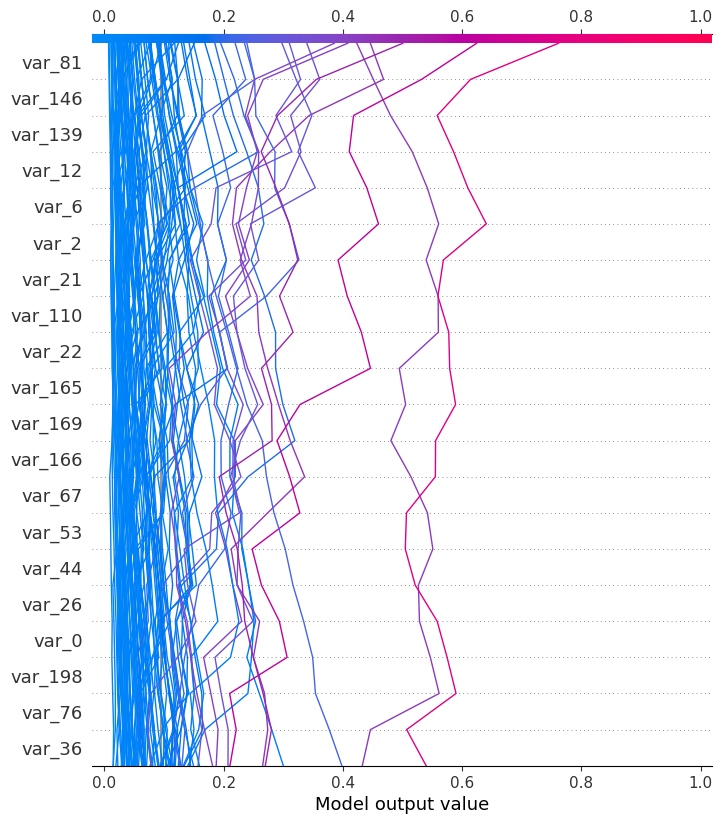

In [18]:
idx = np.random.randint(
    0, x_valid.shape[0], 100
)

shap.decision_plot(
    explainer.expected_value,
    shap_values[idx, :],
    x_valid.iloc[idx,:],
    link="logit")

## 3.3. Важность признаков для модели

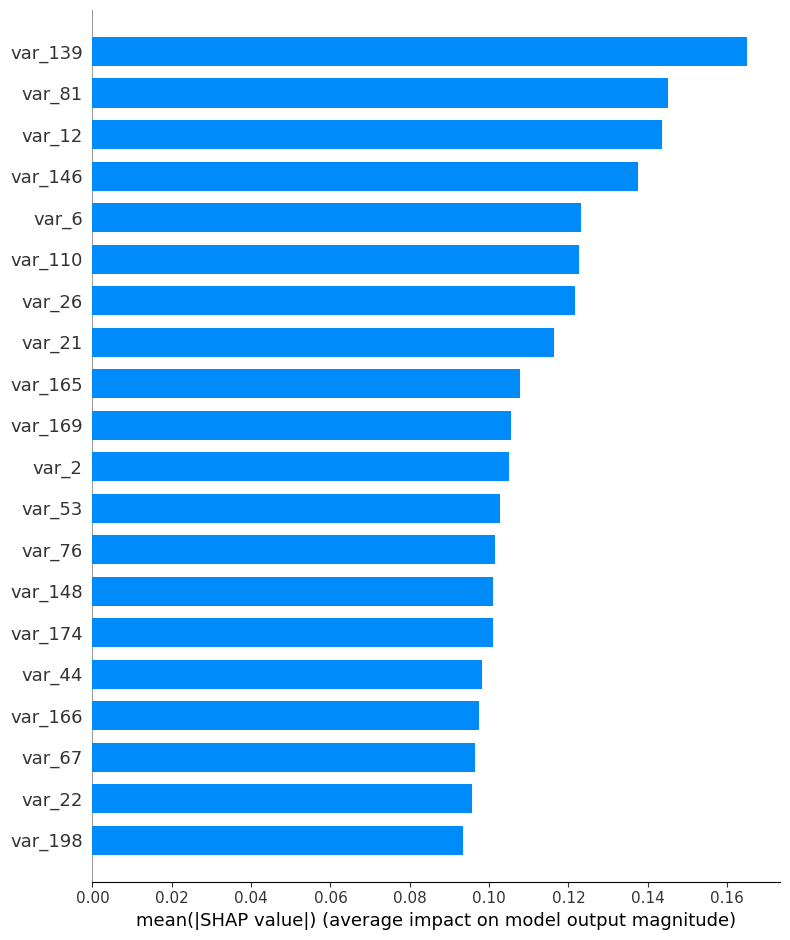

In [19]:
shap.summary_plot(
    shap_values, x_valid, plot_type="bar", max_display=20
)

## 3.4. Взаимодействие признаков между собой

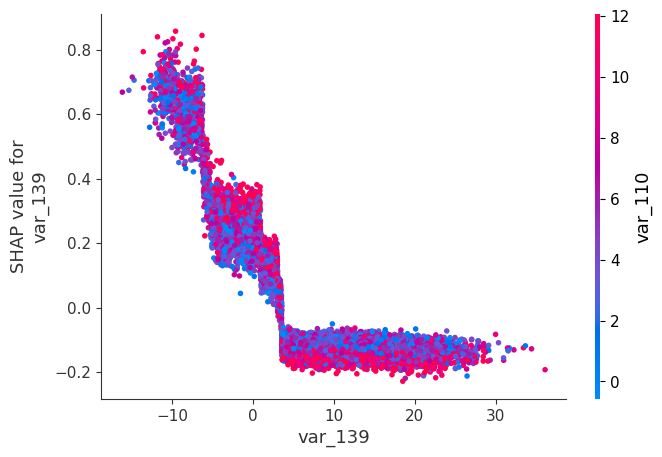

In [20]:
shap.dependence_plot("var_139", shap_values, x_valid)

## 3.5. Суммарный эффект для всех признаков

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


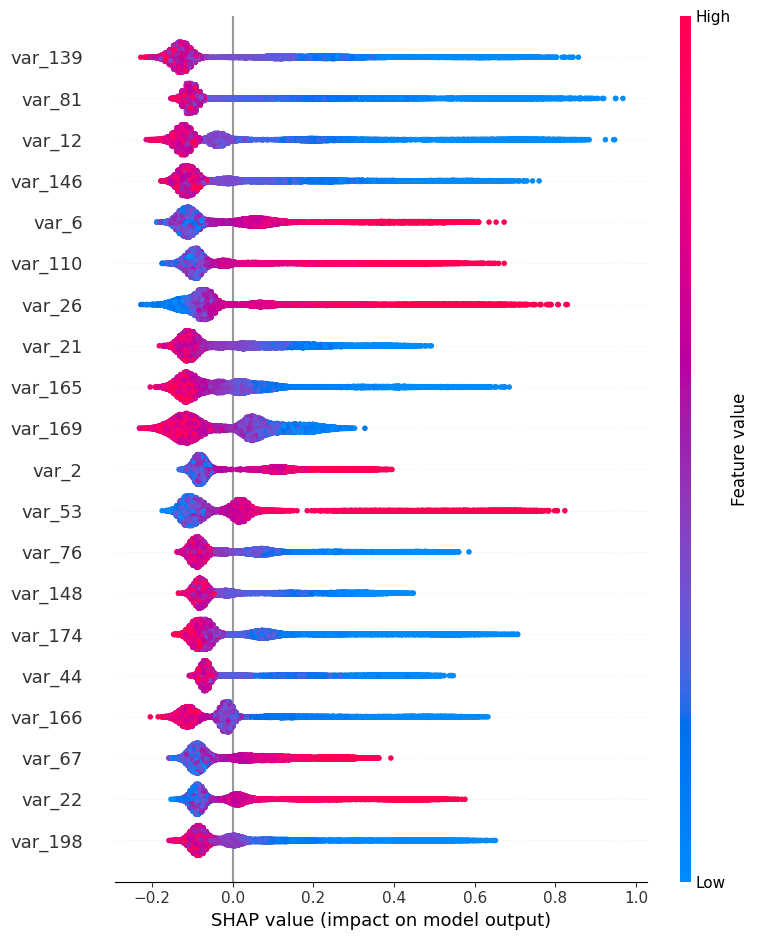

In [21]:
shap.summary_plot(shap_values, x_valid)

## 4. Обучение базовой модели CatBoost (sklearn-API)

`CatBoost` поддерживает как свое собственное `API`, так и `sklearn-API`.

In [22]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(x_train, y_train)

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.050823
0:	learn: 0.6493764	total: 80.5ms	remaining: 1m 20s
1:	learn: 0.6110148	total: 97.4ms	remaining: 48.6s
2:	learn: 0.5771441	total: 114ms	remaining: 37.8s
3:	learn: 0.5469271	total: 131ms	remaining: 32.7s
4:	learn: 0.5202960	total: 148ms	remaining: 29.5s
5:	learn: 0.4967743	total: 165ms	remaining: 27.3s
6:	learn: 0.4755533	total: 183ms	remaining: 25.9s
7:	learn: 0.4570214	total: 201ms	remaining: 24.9s
8:	learn: 0.4408102	total: 220ms	remaining: 24.2s
9:	learn: 0.4261176	total: 239ms	remaining: 23.6s
10:	learn: 0.4135910	total: 259ms	remaining: 23.3s
11:	learn: 0.4027116	total: 283ms	remaining: 23.3s
12:	learn: 0.3924792	total: 310ms	remaining: 23.5s
13:	learn: 0.3837102	total: 340ms	remaining: 23.9s
14:	learn: 0.3762102	total: 379ms	remaining: 24.9s
15:	learn: 0.3689804	total: 426ms	remaining: 26.2s
16:	learn: 0.3626764	total: 486ms	remaining: 28.1s
17:	learn: 0.3565416	total: 527ms	remaining: 28.7s
18:	learn: 0.3513019	total: 557ms	remaining: 28.8s
19:	lear

In [23]:
y_pred = model.predict_proba(x_valid)
score = roc_auc_score(y_valid, y_pred[:, 1])
print(f"score = {round(score, 4)}")

score = 0.8747


## 5. Обучение модели CatBoost с использование оригинального API

In [24]:
cb_params = {
    "n_estimators": 5000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

cb_train = cb.Pool(
    data=x_train, label=y_train, cat_features=None
)
cb_valid = cb.Pool(
    data=x_valid, label=y_valid, cat_features=None
)

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [25]:
model = cb.train(
    params=cb_params,
    dtrain=cb_train,
    eval_set=[cb_train, cb_valid],
    plot=True
)

To draw plots in fit() method you should install ipywidgets and ipython


ImportError: No module named 'ipywidgets'

In [ ]:
catboost_cv = cb.cv(
    pool=cb_train,
    params=cb_params,
    plot=True,
    nfold=3,
    seed=27
)